In [1]:
# use gpd_2023 environment

import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#import seaborn as sns
import pickle
#import torch

import cv2
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [1]:
# Guess you really only need the views_vol.... 


def get_data(test = False):

    local_dir_gen = '/home/simon/Documents/scripts/conflictNet/data/generated'
    local_dir_pro = '/home/simon/Documents/scripts/conflictNet/data/processed'


    if test == False:
        with open(f'{local_dir_gen}/posterior_dict_48_calib.pkl', 'rb') as file:
            posterior_dict = pickle.load(file)

        with open(f'{local_dir_pro}/viewser_monthly_vol_calib_sbnsos.pkl', 'rb') as file: 
            views_vol = pickle.load(file)
            
    else:
        with open(f'{local_dir_gen}/posterior_dict_36_test.pkl', 'rb') as file:
            posterior_dict = pickle.load(file)

        with open(f'{local_dir_pro}/viewser_monthly_vol_test_sbnsos.pkl', 'rb') as file: 
            views_vol = pickle.load(file)

    return posterior_dict, views_vol



In [3]:
#NOT USED YET BELOW!!!!  (the last thing...)


def discard_ME_cells(un_masked_matrix, views_vol, feature):

    # Hard coded...
    # For comparison with views 2020 where middle east is not included

    # 0 is ocean
    # You could load in the views replication data and get the c_id for only africa from there... More kosher
    # middle_east_c_id = [
    #     0.0, 129.0, 130.0, 131.0, 128.0, 132.0, 133.0, 136.0, 55.0, 60.0, 62.0, 89.0,
    #     218.0, 92.0, 220.0, 94.0, 93.0, 96.0, 119.0, 122.0, 124.0, 125.0, 126.0, 127.0
    # ]

    middle_east_c_id = [0.0]

    # Values to mask (0 and 1 in this example)
    values_to_mask = np.array(middle_east_c_id)

    # Create a mask for the specified values
    mask = np.isin(views_vol[-48, :, :, 4], values_to_mask)

    # Mask the array using the created mask
    masked_matrix = np.ma.masked_where(mask, un_masked_matrix[feature, :, :]) # [feature, :, :] is for the feature, i.e. type of violence

    # Get the 1D vector with masked-out values discarded
    #vector = masked_matrix.compressed()

    return masked_matrix#vector



In [4]:
posterior_dict, views_vol = get_data(test = False) # test = True for test data IMPORTANT SETTING!!!!

posterior_list = posterior_dict['posterior_list']
posterior_list_class = posterior_dict['posterior_list_class']
out_of_sample_vol = posterior_dict['out_of_sample_vol']

test_months = out_of_sample_vol.shape[1]

#mean_class_pred = np.array(posterior_list_class[test_months]).mean(axis=0)
#mean_pred = np.array(posterior_list[test_months]).mean(axis=0)

#mean_class_pred = np.median(np.array(posterior_list_class[test_months]), axis=0)
#mean_pred = np.median(np.array(posterior_list[test_months]), axis=0)

mean_class_pred = np.percentile(np.array(posterior_list_class[test_months]), 99.9, axis=0)
mean_pred = np.percentile(np.array(posterior_list[test_months]), 99.9, axis=0)

masked_matrix = discard_ME_cells(mean_class_pred, views_vol, 0)
#masked_matrix = discard_ME_cells(mean_pred, 0)

In [5]:
mean_class_pred.shape

(3, 180, 180)

In [6]:
from scipy.ndimage import zoom

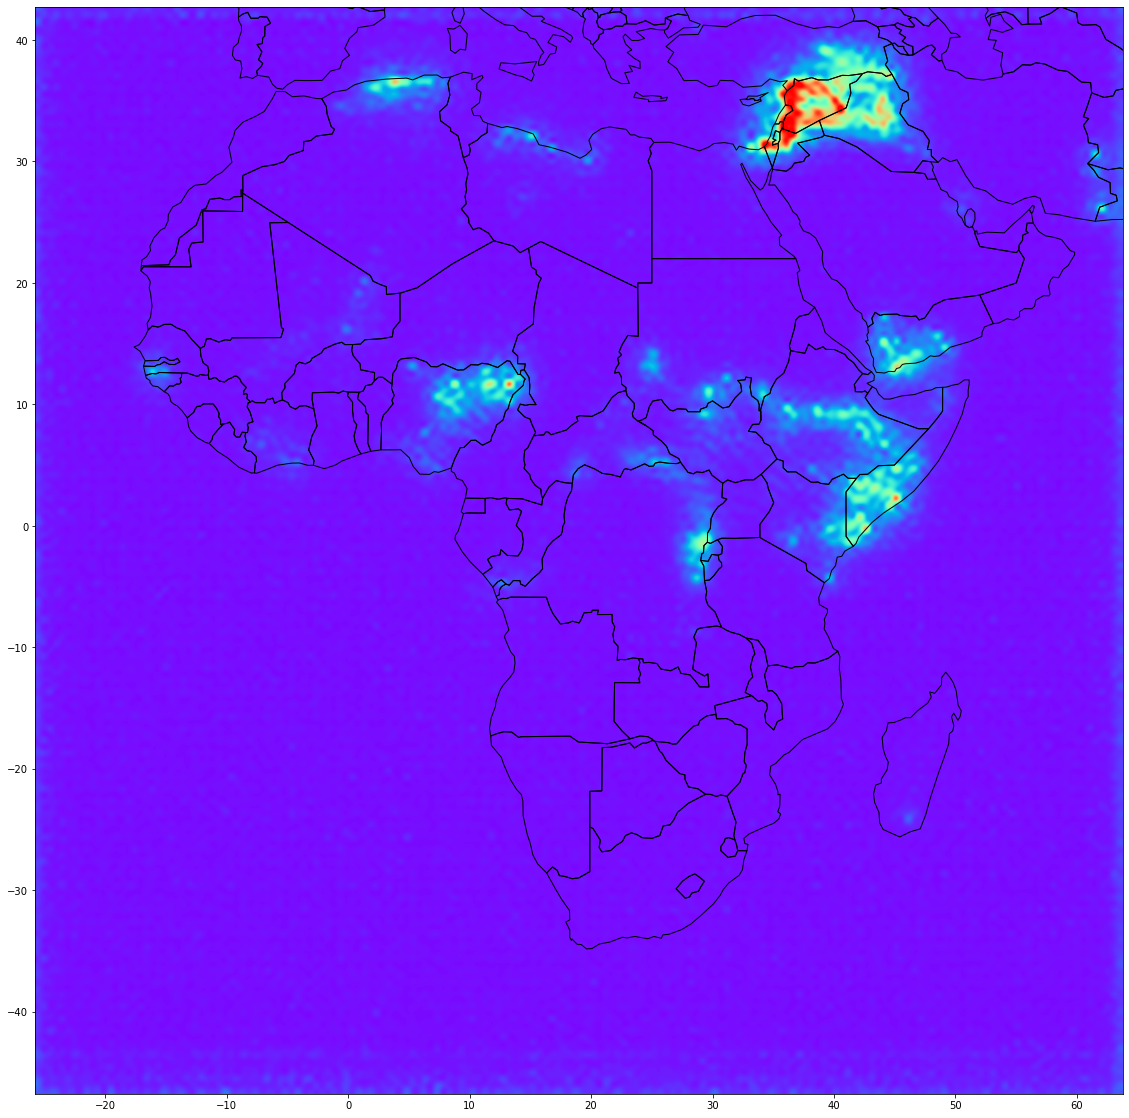

In [11]:

extent = (-25.75, 63.75, -46.75, 42.75)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(30, 20))

# Plot the world map
world.plot(ax=ax, color='none', edgecolor='black')

# Set vmin and vmax for the image
vmin = 0
vmax = 1

scaled_matrix = cv2.resize(masked_matrix, None, fx=10, fy=10, interpolation=cv2.INTER_LANCZOS4)
ax.imshow(scaled_matrix, extent=extent, vmin=vmin, vmax=vmax, cmap='rainbow', alpha=1)

#ax.imshow(masked_matrix, extent=extent, vmin=vmin, vmax=vmax, cmap='rainbow', alpha=1)

plt.show()

In [8]:
vector = masked_matrix.compressed()
vector.shape

(13110,)

In [9]:
masked_matrix.shape

(180, 180)

In [10]:
mean_pred[0,:,:].max()

7.2662406129837045

In [11]:
mean_pred[0,:,:].shape

(180, 180)

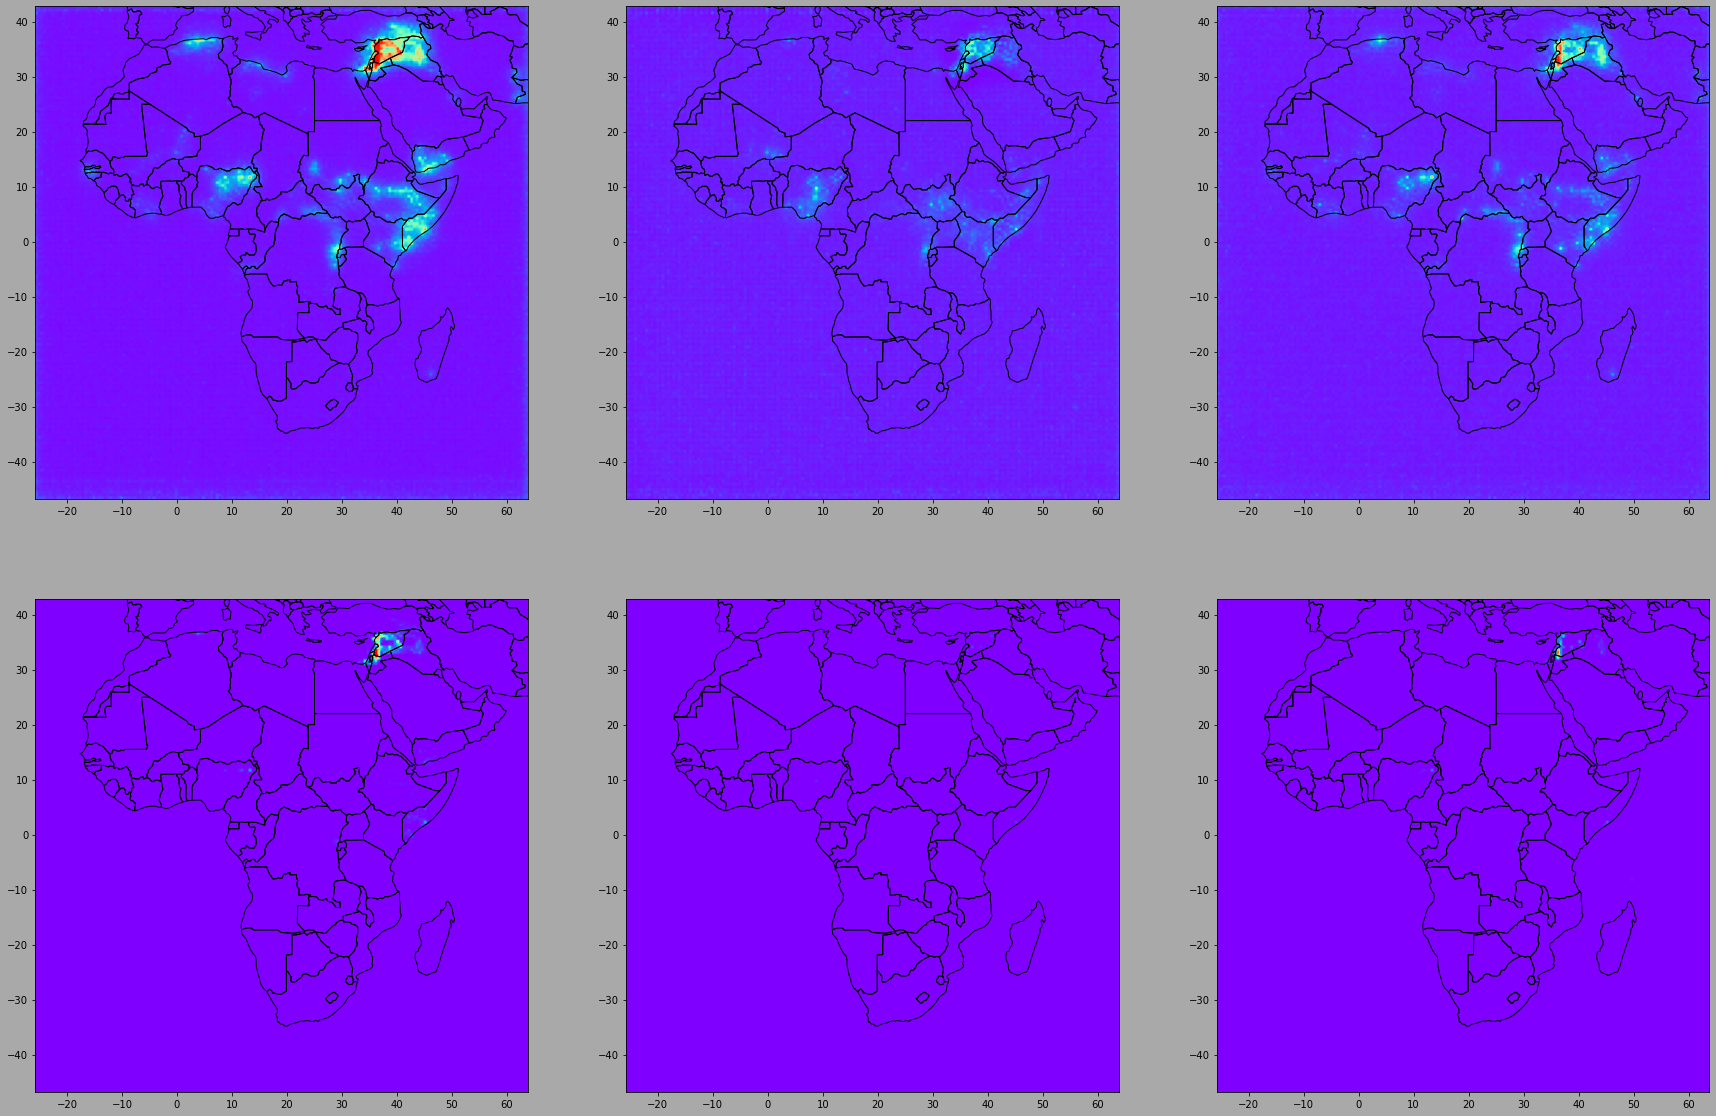

In [12]:
#plt.style.use('dark_background')
#plt.rcParams['savefig.facecolor'] = "0.8"

fig, axs = plt.subplots(2,3, facecolor='darkgrey')

# extent = (views_vol[:,:,:,1].min(), views_vol[:,:,:,1].max(), views_vol[:,:,:,2].min(), views_vol[:,:,:,2].max()) 
extent = (-25.75, 63.75, -46.75, 42.75)

fig.set_figheight(20)
fig.set_figwidth(30)

world.plot(ax = axs[0,0], color='none', edgecolor='black')
world.plot(ax = axs[0,1], color='none', edgecolor='black')
world.plot(ax = axs[0,2], color='none', edgecolor='black')
world.plot(ax = axs[1,0], color='none', edgecolor='black')
world.plot(ax = axs[1,1], color='none', edgecolor='black')
world.plot(ax = axs[1,2], color='none', edgecolor='black')

axs[0,0].imshow(mean_class_pred[0,:,:], extent = extent, cmap='rainbow', vmin = 0, vmax = 1)
axs[0,1].imshow(mean_class_pred[1,:,:], extent = extent, cmap='rainbow', vmin = 0, vmax = 1)
axs[0,2].imshow(mean_class_pred[2,:,:], extent = extent, cmap='rainbow', vmin = 0, vmax = 1)
axs[1,0].imshow(mean_pred[0,:,:], extent = extent, cmap='rainbow', vmin = 0, vmax = 6)
axs[1,1].imshow(mean_pred[1,:,:], extent = extent, cmap='rainbow', vmin = 0, vmax = 6)
axs[1,2].imshow(mean_pred[2,:,:], extent = extent, cmap='rainbow', vmin = 0, vmax = 6)

plt.show()

In [13]:
# insert overall ap score.

def plt_trio(test_months, posterior_dict, feature_number):
    
    timelaps_dir = '/home/simon/Documents/scripts/conflictNet/reports/timelapse/feature'

    interpolation = 'none'

    facecolor1 = '#534f63' #'#222129' #'#ededf0' #'#4d4c4c' #'#2c2b2b'#222129'
    facecolor2 = '#848099' #'#cdcbcb' #'#5a5858'
    facecolor3 = '#f1f1f4'
    tick_color = 'white'
    
    
    # extent = (views_vol[:,:,:,1].min(), views_vol[:,:,:,1].max(), views_vol[:,:,:,2].min(), views_vol[:,:,:,2].max())
    extent = (-25.75, 63.75, -46.75, 42.75) # hardcode so you do not have to load views_vol

#    extent = (-100, 80, -100, 80) 


    posterior_list = posterior_dict['posterior_list']
    posterior_list_class = posterior_dict['posterior_list_class']
    out_of_sample_vol = posterior_dict['out_of_sample_vol']

    mean_class_pred = np.array(posterior_list_class[test_months]).mean(axis=0)[feature_number,:,:]
    mean_pred = np.array(posterior_list[test_months]).mean(axis=0)[feature_number,:,:]
    true_obs = out_of_sample_vol[:,test_months,:,:].squeeze()[feature_number,:,:]

    std_pred = np.array(posterior_list[test_months]).std(axis=0)[feature_number,:,:]

    # min/max for plotting
    min_true = out_of_sample_vol[:,0,:,:].min()
    max_true = out_of_sample_vol[:,0,:,:].max()
    min_pred = 0#np.array(posterior_list).min()
    max_pred = out_of_sample_vol[:,0,:,:].max()#mean_pred.max()#np.array(posterior_list).max()
    min_pred_class = 0 # np.array(posterior_list_class).min()
    max_pres_class = 1 # np.array(posterior_list_class).max()

    min_pred_std = 0# np.array(posterior_list).mean(axis=0).std(axis = 0).min()
    max_pred_std = np.array(posterior_list).mean(axis=0).std(axis = 0).max()

    all_abs_error = np.abs(out_of_sample_vol[:,0,:,:].squeeze() - np.array(posterior_list).mean(axis = 0))
    min_error = all_abs_error.min()
    max_error = all_abs_error.max()

    # abs error
    abs_error = np.abs(true_obs - mean_pred)


    # Confucsion
    threshold = 0.3 # there is a good way to do this... You have just forgotten it...

    binary_pred = (mean_class_pred > threshold) * 1 
    binary_true = (true_obs > 0)*1

    TP = ((binary_pred == 1) & (binary_true == 1)).astype('int')
    FP = ((binary_pred == 1) & (binary_true == 0)).astype('int')*2
    FN = ((binary_pred == 0) & (binary_true == 1)).astype('int')*3
    # TN = ((binary_pred == 0) & (binary_true == 0)).astype('int')*4


    confusion_map = TP + FP + FN #+ TN # TN per defualt 0

    # TN gray, TP green, FP blue, FN red
    colors = [ (0.5, 0.5, 0.5), (0, 1, 0), (0, 0, 1), (1, 0, 0)]  # R, G, B
    cmap_name = 'catagorical4'
    cat_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=4)

    # plot
    #plt.figure(figsize=[30,20])

    fig, axs = plt.subplots(2,3, sharey= True, sharex= True, layout="compressed", facecolor=facecolor1)
    
    fig.set_figheight(20)
    fig.set_figwidth(32)

    #plt.subplots_adjust(wspace=0.2, hspace=-0.2)

    #axs[0,0].set_title(f'true, month {test_months}', loc='left')

   # Add a text annotation inside the plot, in the lower left corner
    axs[0, 0].text(0.05, 0.05, f'Observed Magnitude y, ln(best+1), Month {test_months}', transform=axs[0, 0].transAxes, va='bottom', ha='left', fontsize=20, color='black', bbox=dict(facecolor=facecolor3, alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5')) 
    true_obs_masked =  np.ma.masked_where((views_vol[-48,:,:,4] == 0), true_obs)
    world.plot(ax = axs[0,0], color='none', edgecolor='black')
    im = axs[0,0].imshow(true_obs_masked, cmap = 'rainbow', vmin= min_true, vmax=max_true, aspect= 'equal', interpolation = interpolation, extent = extent)
    cbar = plt.colorbar(im, ax = axs[0,0], shrink = 1, pad= 0) #, label = 'observed magnitude y, i.e. log(best)')
    #cbar.ax.tick_params(direction='in', pad = -24, labelsize = 16, labelcolor = 'black')    # set axis spines (the box around the plot) to be invisible
    cbar.ax.tick_params(direction='out', pad = 4, labelsize = 16, labelcolor = tick_color)    # set axis spines (the box around the plot) to be invisible
    plt.setp(ax.spines.values(), alpha = 0)
    axs[0,0].tick_params(which = 'both', size = 0, labelsize = 0)

    #axs[0,1].set_title(f'pred, month {test_months}')
    axs[0,1].text(0.05, 0.05, f'Predictited Magnitude, ŷ, Month {test_months}', transform=axs[0, 1].transAxes, va='bottom', ha='left', fontsize=20, color='black', bbox=dict(facecolor=facecolor3, alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))    
    mean_pred_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), mean_pred)
    world.plot(ax = axs[0,1],color='none', edgecolor='black', figsize = [25,25])
    im = axs[0,1].imshow(mean_pred_masked, cmap = 'rainbow', vmin= min_pred, vmax=max_pred, aspect= 'equal', interpolation = interpolation, extent = extent)
    cbar = plt.colorbar(im, ax = axs[0,1], shrink = 1, pad=0) #, label = 'predictited magnitude, ŷ ')
    #cbar.set_label('Predictited Magnitude, ŷ', rotation=270, labelpad=-22, fontsize=12, color='black')
    cbar.ax.tick_params(direction='out', pad = 4, labelsize = 16, labelcolor = tick_color)    # set axis spines (the box around the plot) to be invisible
    # set axis spines (the box around the plot) to be invisible
    plt.setp(ax.spines.values(), alpha = 0)
    axs[0,1].tick_params(which = 'both', size = 0, labelsize = 0)

    #axs[0,2].set_title(f'pred class, month {test_months}')
    axs[0,2].text(0.05, 0.05, f'Predictited Probability, ỹ, Month {test_months}', transform=axs[0, 2].transAxes, va='bottom', ha='left', fontsize=20, color='black', bbox=dict(facecolor=facecolor3, alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))    
    mean_class_pred_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), mean_class_pred)
    world.plot(ax = axs[0,2],color='none', edgecolor='black', figsize = [25,25])
    im = axs[0,2].imshow(mean_class_pred_masked, cmap = 'rainbow', vmin= min_pred_class, vmax=max_pres_class, aspect= 'equal', interpolation = interpolation, extent = extent)
    cbar = plt.colorbar(im, ax = axs[0,2], shrink = 1, pad=0) #, label = 'predictited probability, ỹ')
    #cbar.set_label('Predictited Probability, ỹ', rotation=270, labelpad=-32, fontsize=12, color='black')
    cbar.ax.tick_params(direction='out', pad = 4, labelsize = 16, labelcolor = tick_color)    # set axis spines (the box around the plot) to be invisible
    # set axis spines (the box around the plot) to be invisible
    plt.setp(ax.spines.values(), alpha = 0)
    # set both tick marks and tick labels to size 0
    axs[0,2].tick_params(which = 'both', size = 0, labelsize = 0)

    #axs[1,0].set_title(f'absolute error, month {test_months}')
    
    axs[1,0].text(0.05, 0.05, f'Absolute Error, |y-ŷ|, Month {test_months}', transform=axs[1, 0].transAxes, va='bottom', ha='left', fontsize=20, color='black', bbox=dict(facecolor=facecolor3, alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    abs_error_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), abs_error)
    world.plot(ax = axs[1,0],color='none', edgecolor='black', figsize = [25,25])
    im = axs[1,0].imshow(abs_error_masked, cmap = 'rainbow', vmin=min_error, vmax=max_error, aspect= 'equal', interpolation = interpolation, extent = extent) # min and max are not constant here!
    cbar = plt.colorbar(im, ax = axs[1,0], shrink = 1, pad = 0) #, label = 'absolute error, |y-ŷ|')
    #cbar.set_label('Absolute Error, |y-ŷ|', rotation=270, labelpad=-32, fontsize=12, color='black')
    cbar.ax.tick_params(direction='out', pad = 4, labelsize = 16, labelcolor = tick_color)    # set axis spines (the box around the plot) to be invisible
    # set axis spines (the box around the plot) to be invisible
    plt.setp(ax.spines.values(), alpha = 0)
    # set both tick marks and tick labels to size 0
    axs[1,0].tick_params(which = 'both', size = 0, labelsize = 0)

    #axs[1,1].set_title(f'pred std, month {test_months}')  # wonrg title
    
    axs[1,1].text(0.05, 0.05, f'Ensemble Std (predicted magnitude, ŷ), Month {test_months}', transform=axs[1, 1].transAxes, va='bottom', ha='left', fontsize=20, color='black', bbox=dict(facecolor=facecolor3, alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    std_pred_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), std_pred)
    world.plot(ax = axs[1,1],color='none', edgecolor='black', figsize = [25,25])
    im = axs[1,1].imshow(std_pred_masked, cmap = 'rainbow', vmin=min_pred_std, vmax=max_pred_std, aspect= 'equal', interpolation = interpolation, extent = extent)
    cbar = plt.colorbar(im, ax = axs[1,1], shrink = 1, pad = 0)#,  label = 'ensemble std (predicted magnitude, ŷ)')
    #cbar.set_label('Ensemble Std (predicted magnitude, ŷ)', rotation=270, labelpad=-38, fontsize=12, color='black')
    cbar.ax.tick_params(direction='out', pad = 4, labelsize = 16, labelcolor = tick_color)    # set axis spines (the box around the plot) to be invisible
    # set axis spines (the box around the plot) to be invisible
    plt.setp(ax.spines.values(), alpha = 0)
    # set both tick marks and tick labels to size 0
    axs[1,1].tick_params(which = 'both', size = 0, labelsize = 0)

    #axs[1,2].set_title(f'confusion_map (T=0.3)pred std, month {test_months}')  # wonrg title
    
    axs[1,2].text(0.05, 0.05, f'Confusion Map (T=0.3), Month {test_months}', transform=axs[1, 2].transAxes, va='bottom', ha='left', fontsize=20, color='black', bbox=dict(facecolor=facecolor3, alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    confusion_map_masked =  np.ma.masked_where((views_vol[-48,:,:,4] == 0), confusion_map)
    world.plot(ax = axs[1,2],color='none', edgecolor='black', figsize = [25,25])
    im = axs[1,2].imshow(confusion_map_masked, cmap = cat_cmap, vmin=0, vmax=3, aspect= 'equal', interpolation = interpolation, extent = extent)
    cbar = plt.colorbar(im, ax = axs[1,2], ticks = np.linspace(0.4,2.6,4), shrink = 1, pad = 0)
    cbar.set_ticklabels(['TN', 'TP', 'FP', 'FN'])
    cbar.ax.tick_params(direction='out', pad = 4, labelsize = 16, labelcolor = tick_color)    # set axis spines (the box around the plot) to be invisible
    # set axis spines (the box around the plot) to be invisible
    plt.setp(ax.spines.values(), alpha = 0)
    # set both tick marks and tick labels to size 0
    axs[1,2].tick_params(which = 'both', size = 0, labelsize = 0)


    # back ground color
    axs[0,0].set_facecolor(facecolor2)
    axs[0,1].set_facecolor(facecolor2)
    axs[0,2].set_facecolor(facecolor2)
    axs[1,0].set_facecolor(facecolor2)   
    axs[1,1].set_facecolor(facecolor2)
    axs[1,2].set_facecolor(facecolor2)


    #plt.subplots_adjust(hspace = -0.1, wspace = 0.1)
    fig_title = f'trio_{str(test_months).zfill(2)}'
    plt.savefig(timelaps_dir + str(feature_number) + '/' + fig_title + '.tiff', bbox_inches="tight", format='tiff', facecolor=facecolor1, dpi=300)
    
    #plt.show()
    
    #plt.cla() # idk if this is also needed..
    #plt.clf() # idk if this is also needed..
    plt.close(fig) # so they do not display or take up mem
    #gc.collect()

In [14]:
#plt_trio(0, timelaps_dir, posterior_dict, 0)

In [15]:
#plt_trio(0, timelaps_dir, posterior_dict, 1)

In [16]:
#plt_trio(0, timelaps_dir, posterior_dict, 2)

In [17]:
for i in range(test_months):
    plt_trio(i, posterior_dict, 0)

In [ ]:
for i in range(test_months):
    plt_trio(i, posterior_dict, 1)

In [ ]:
for i in range(test_months):
    plt_trio(i, posterior_dict, 2)